Headers

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.ndimage import zoom
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import Reshape
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import BatchNormalization
import math
import tifffile
import os
from pickle import load
import numpy as np
import imageio
from matplotlib import pyplot as plt
from keras.layers import Conv2DTranspose

Preprocessing data

In [3]:
#function to slice the image
def slicing(lr_train_images, subset_size):

    # Calculate the number of subsets
    num_subsets = np.array(lr_train_images.shape[:2]) // subset_size

    # Initialize an empty list to store the subsets
    subsets = []

    # Loop over the number of subsets in rows and columns
    for i in range(num_subsets[0]):
        for j in range(num_subsets[1]):
            # Calculate the starting indices of the subset
            start_row = i * subset_size
            start_col = j * subset_size

            # Extract the subset from the image
            subset = lr_train_images[start_row:start_row+subset_size, start_col:start_col+subset_size]

            # Append the subset to the list
            subsets.append(subset)

    # Convert the list of subsets to a numpy array
    subsets_array = np.array(subsets)

    return subsets_array

In [4]:
#function to preprocess
def preprocess_image(image, no, count):
    count += 1
    image_np = np.array(image)
    print(f'the image {count} min: {np.min(image)}')
    print(f'the image {count} max: {np.max(image)}')
    print(f'the image {count} mean: {np.mean(image)}')
    # print(f'the image {count} mean: {np.min(image)-np.mean(image)}')
    print(f'the dimension of {count} image: {image_np.shape}')
    min_value = np.min(image_np)
    max_value = np.max(image_np)
    image_np = (image_np - min_value) * (2.0) / (max_value - min_value) - 1.0

    # Perform slicing on the preprocessed array
    image_np_x_slice = slicing(image_np, no)
    image_np_x_slice1 = None

    if no == 128:
        # Set the desired scale factor for upsampling
        scale_factor = 2
        # Upsample the image using zoom
        image_np_x_slice1 = zoom(image_np_x_slice, (1, scale_factor, scale_factor, 1), order=3)
        image_np_x_slice1.shape
    else:
        image_np_x_slice1 = image_np_x_slice

    return image_np_x_slice1, count

In [5]:
def data_augmentation(images):

    #Create empty arrays to store rotation and flipped images
    rotated_90 = np.empty_like(images)
    rotated_180 = np.empty_like(images)
    rotated_270 = np.empty_like(images)
    flipped_horizontal = np.empty_like(images)
    flipped_vertical = np.empty_like(images)

    # Rotate each image in the ndarray
    for i in range(images.shape[0]):
        for j in range(images.shape[3]):
            rotated_90[i, :, :, j] = np.rot90(images[i, :, :, j], k=1)
            rotated_180[i, :, :, j] = np.rot90(images[i, :, :, j], k=2)
            rotated_270[i, :, :, j] = np.rot90(images[i, :, :, j], k=3)
            flipped_horizontal[i, :, :, j] = np.flip(images[i, :, :, j], axis=1)
            flipped_vertical[i, :, :, j] = np.flip(images[i, :, :, j], axis=0)


    # Concatenate the original, rotated, flipped horizontally, and flipped vertically images
    final_images = np.concatenate((images, rotated_90, rotated_180, rotated_270, flipped_horizontal, flipped_vertical), axis=0)

    return final_images

In [1]:
cd ../

C:\Users\otiwa\final_year_project


In [8]:
#training examples
# Folder path containing the images
folder_path = 'auto-encoder/dataset/ls'

# List all files in the folder
file_list = os.listdir(folder_path)
# file_list[0], file_list[1] = file_list[1], file_list[0]
print(file_list)
# Iterate over the files and preprocess the images
count = 0
preprocessed_images = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        image = imageio.imread(file_path)
        preprocessed_image, count = preprocess_image(image, 128, count)
        preprocessed_images.append(preprocessed_image)


# Convert the list of preprocessed images to a NumPy array
preprocessed_array = np.array(preprocessed_images)
preprocessed_array = preprocessed_array.reshape(preprocessed_array.shape[0], -1)

for i, j in enumerate(range(preprocessed_array.shape[0])):
    print(f"the ouput dimension for image {i}: {preprocessed_array[j][0].shape}")
    count = i

training_sample = np.concatenate((preprocessed_array[0][0], preprocessed_array[1][0]), axis=0)

#data augmentation
training_sample = data_augmentation(training_sample)
print(f'shape of training example: {training_sample.shape}')

['01jan19_merged_sample1_ls.tif', '01jan19_merged_sample2_ls.tif']
the image 1 min: 1.0
the image 1 max: 1337.0
the image 1 mean: 373.217041015625
the dimension of 1 image: (295, 569, 4)
the image 2 min: 2.0
the image 2 max: 1311.0
the image 2 mean: 362.4297180175781
the dimension of 2 image: (567, 572, 4)


C:\Users\otiwa\AppData\Local\Temp\ipykernel_32604\3537508318.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preprocessed_array = np.array(preprocessed_images)


the ouput dimension for image 0: (8, 256, 256, 4)
the ouput dimension for image 1: (16, 256, 256, 4)
shape of training example: (144, 256, 256, 4)


In [57]:
training_sample.min()

-1.0043683

In [7]:
#testing examples
# Folder path containing the images
folder_path = 'auto-encoder/dataset/hs'

# List all files in the folder
file_list = os.listdir(folder_path)
print(file_list)
# Iterate over the files and preprocess the images
count = 0
preprocessed_images = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        image = imageio.imread(file_path)
        preprocessed_image, count = preprocess_image(image, 256, count)
        preprocessed_images.append(preprocessed_image)


# Convert the list of preprocessed images to a NumPy array
preprocessed_array = np.array(preprocessed_images)
preprocessed_array = preprocessed_array.reshape(preprocessed_array.shape[0], -1)

for i, j in enumerate(range(preprocessed_array.shape[0])):
    print(f"the ouput dimension for image {i}: {preprocessed_array[j][0].shape}")
    count = i

testing_sample = np.concatenate((preprocessed_array[0][0], preprocessed_array[1][0]), axis=0)

#data_augmentation
testing_sample = data_augmentation(testing_sample)
print(f'shape of training example: {testing_sample.shape}')

['15jan19_merged_sample1_hs.tif', '15may19_merged_sample2_hs.tif']
the image 1 min: 1.0
the image 1 max: 266.0
the image 1 mean: 95.2601547241211
the dimension of 1 image: (589, 1138, 4)
the image 2 min: 24.0
the image 2 max: 598.0
the image 2 mean: 152.09535217285156
the dimension of 2 image: (1134, 1144, 4)
the ouput dimension for image 0: (8, 256, 256, 4)
the ouput dimension for image 1: (16, 256, 256, 4)


C:\Users\otiwa\AppData\Local\Temp\ipykernel_32604\1038610409.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preprocessed_array = np.array(preprocessed_images)


shape of training example: (144, 256, 256, 4)


In [10]:
testing_sample.min()

-1.0

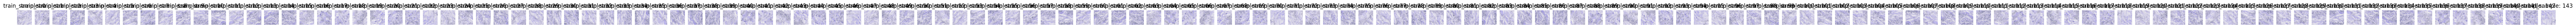

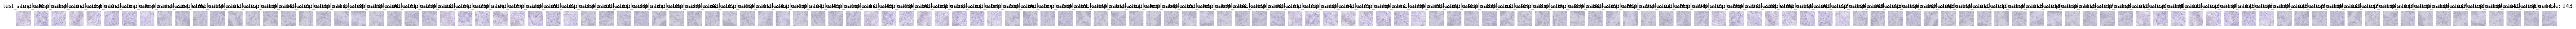

In [9]:
# #displaying the images
# def display(image, label= 'input'):
#     num_img = image.shape[0]

#     fig, axes = plt.subplots(1, num_img, figsize=(100, 50))

#     for i in range(num_img):
#         axes[i].imshow(image[i, :, :, :4])
#         axes[i].set_title(f'{label}: {i}')
#         axes[i].axis('off')
#     plt.show()

# display(training_sample, 'train_sample')
# display(testing_sample, 'test_sample')
# # display(image_np_test_slice, 'input test')

antoencoder architecture

In [54]:
def auto_encoder(model, img_h=256, img_w=256, learning_rate=0.001):

    #encoder model
    input1 = Input(shape=(img_h, img_w, 4))
    encoder_output1 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input1)
    encoder_output2 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_output1)
    encoder_output3 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoder_output2)
    encoder_output4 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoder_output3)
    #latent space
    decoder_output = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(encoder_output4)

    #decoder model
    decoder_output1 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(decoder_output)
    
    decoder_output2 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(decoder_output1)
    decoder_output2 = BatchNormalization()(decoder_output2)
    decoder_output2_skip = Add()([encoder_output3, decoder_output2])

    decoder_output3 = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(decoder_output2_skip)
    
    decoder_output4 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(decoder_output3)
    decoder_output4 = BatchNormalization()(decoder_output4)
    decoder_output4_skip = Add()([encoder_output1, decoder_output4])
    decoder_output5 = Conv2DTranspose(4, (3, 3), activation='tanh', padding='same', strides=2)(decoder_output4_skip) 
    decoder_output5_skip = Add()([input1, decoder_output5])

    model = Model(inputs=input1, outputs=decoder_output5_skip)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['acc'])

    # summarize model
    print(model.summary())

    return model

In [55]:
# Create the model outside the TensorFlow function
model = auto_encoder(model= None, img_h=256, img_w=256)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 16  592         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 64, 64, 32)   4640        ['conv2d_95[0][0]']              
                                                                                           

training the model

In [ ]:
model.fit(training_sample, testing_sample, batch_size=1, epochs=50)

In [31]:
# Save the model weights to the current directory
model.save_weights('autoencoder_weights_new.h5')

In [68]:
training_sample[1].shape

(256, 256, 4)

predicting the output

In [32]:
# Rebuild the autoencoder model
model = auto_encoder(model=None, img_h=256, img_w=256)

# Load the saved weights
model.load_weights('autoencoder_weights_new.h5')

# Generate predictions
predictions = model.predict(training_sample)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 128, 128, 16  592         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 64, 64, 32)   4640        ['conv2d_45[0][0]']              
                                                                                            

In [74]:
print(predictions.max())

0.32273692


In [78]:
def bring_them_back(images):
    min_value = np.min(images)
    max_value = np.max(images)
    images_rec = (((images + 1) * (max_value - min_value)) / 2) + min_value
    return images_rec

In [79]:
boo = bring_them_back(training_sample)

In [82]:
boo.max()

1.0300488

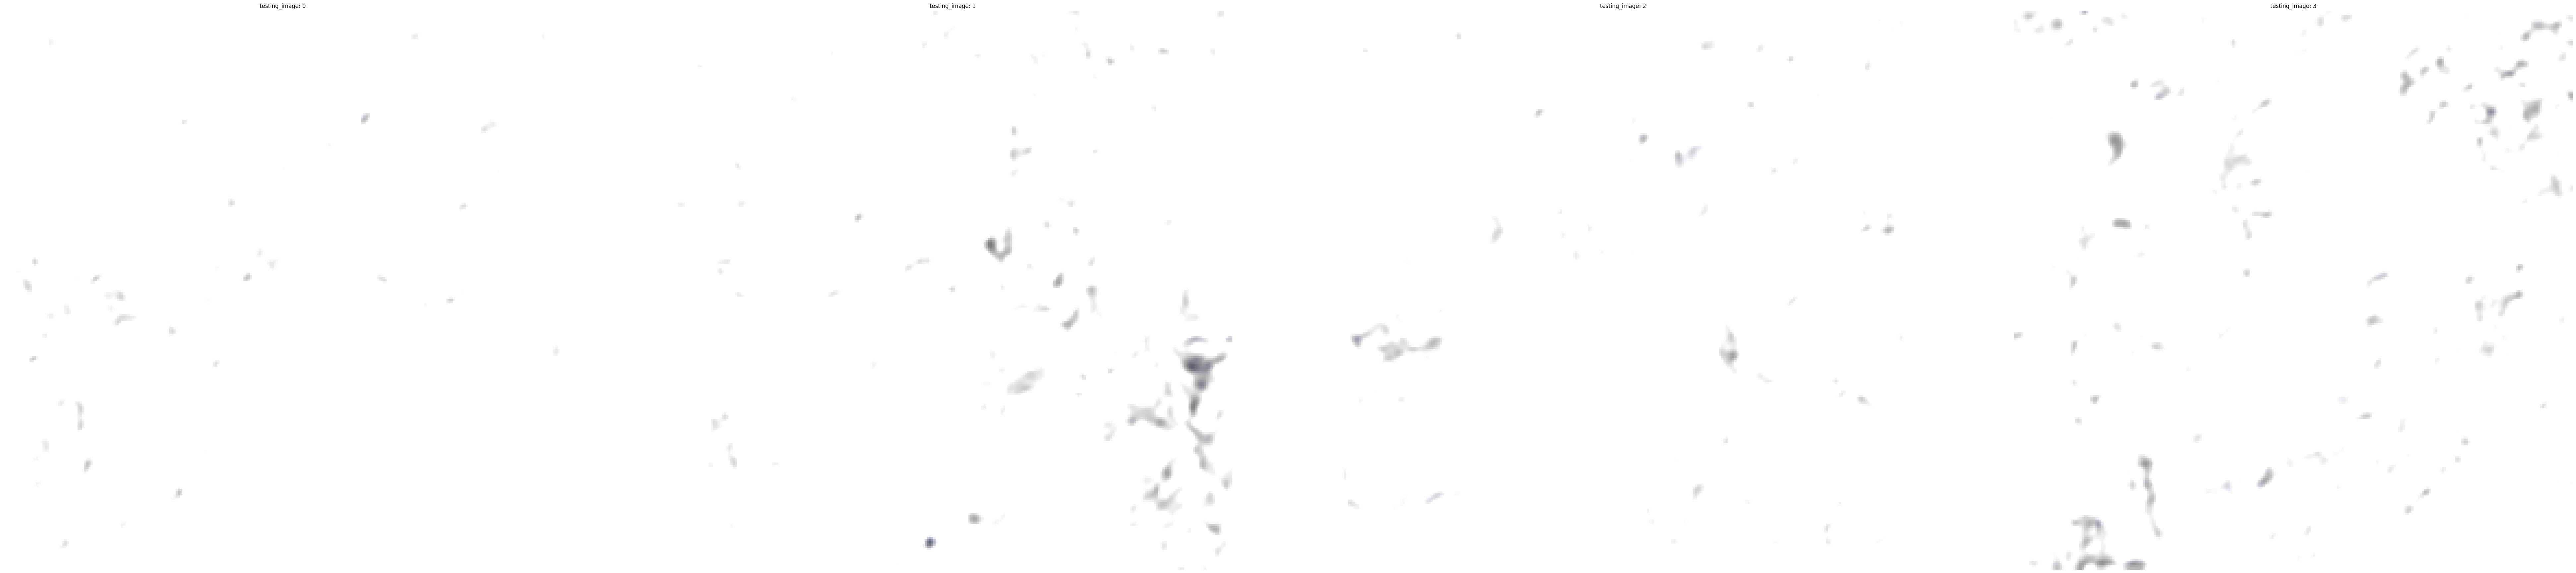

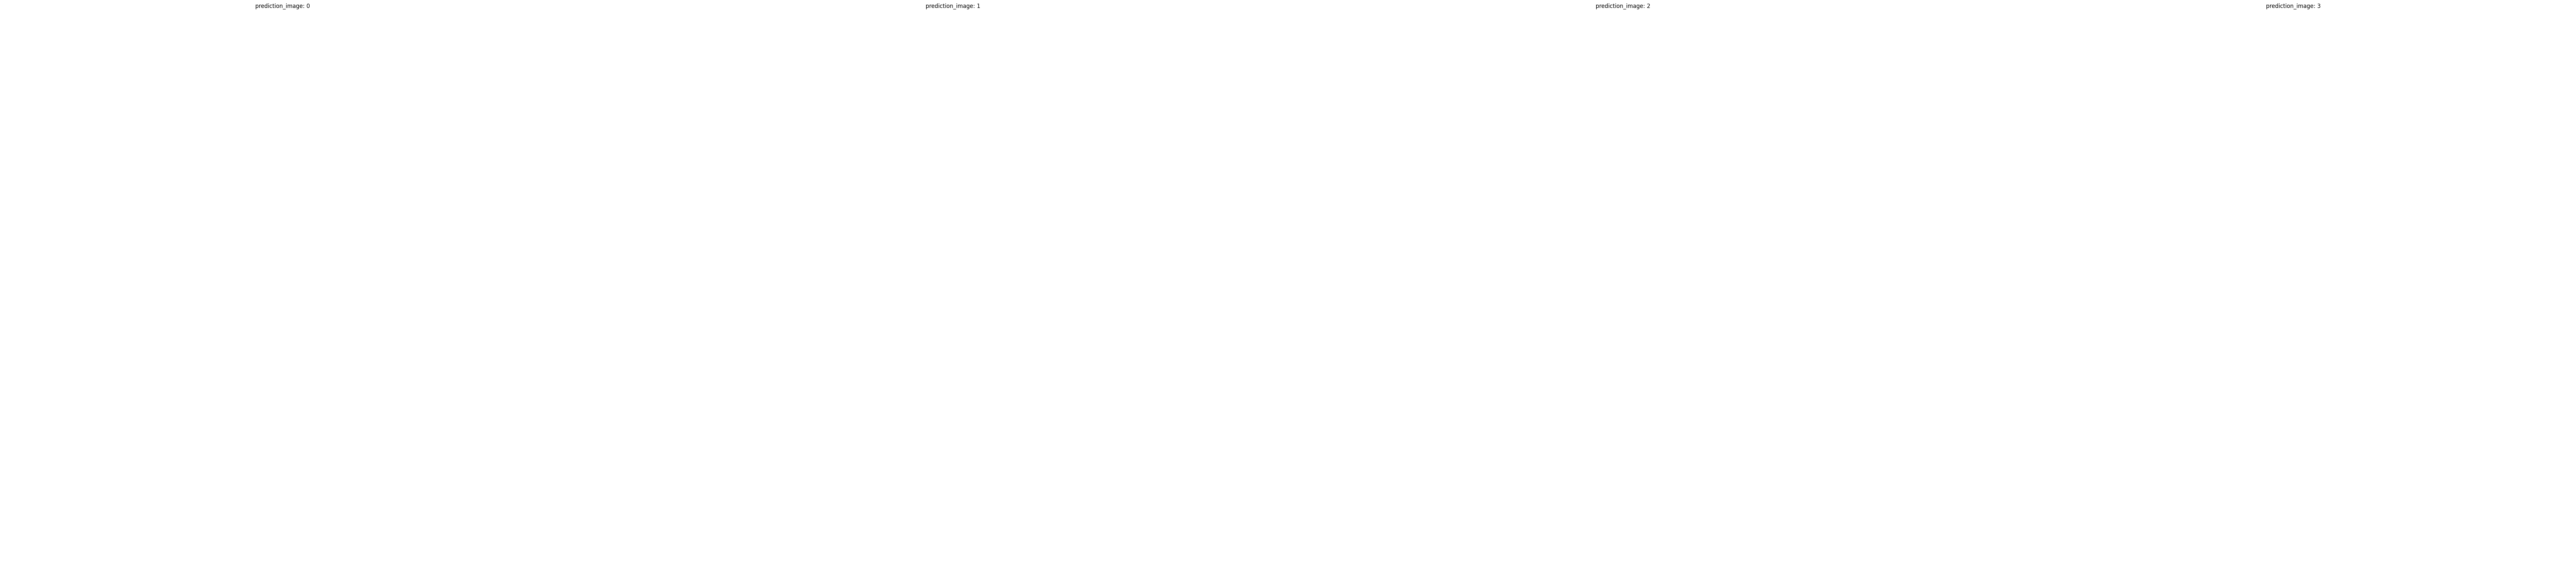

In [72]:
display(training_sample[:4], 'testing_image')
display(predictions[:4], 'prediction_image')

saving the ouput

In [ ]:
cd ../

In [33]:
# Convert the data type of the predictions array to a suitable format
# Modify this based on the requirements of your predicted output
# predictions = predictions.squeeze()  # Remove singleton dimensions if present
# predictions = np.uint8(predictions * 255)  # Scale values to 0-255 range and convert to uint8

# Create a directory to save the predictions if it doesn't exist
directory = r'auto-encoder/dataset/prediction'
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(predictions.shape[0]):
    # Save the predicted output as a TIFF file
    output_path = os.path.join(directory, f'predicted{[i]}.tif')
    tifffile.imwrite(output_path, predictions[i], planarconfig='contig')

# Display a download link
print(f"Download the predicted output: [predicted_output.tif]({output_path})")

Download the predicted output: [predicted_output.tif](auto-encoder/dataset/prediction\predicted[143].tif)


In [34]:
# Create a directory to save the predictions if it doesn't exist
directory = r'auto-encoder/dataset/input'
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(predictions.shape[0]):
    # Save the predicted output as a TIFF file
    output_path = os.path.join(directory, f'real_input{[i]}.tif')
    tifffile.imwrite(output_path, training_sample[i], planarconfig='contig')

# Display a download link
print(f"Download the predicted output: [predicted_output.tif]({output_path})")

Download the predicted output: [predicted_output.tif](auto-encoder/dataset/input\real_input[143].tif)


In [35]:
# Create a directory to save the predictions if it doesn't exist
directory = r'auto-encoder/dataset/output'
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(predictions.shape[0]):
    # Save the predicted output as a TIFF file
    output_path = os.path.join(directory, f'real_output{[i]}.tif')
    tifffile.imwrite(output_path, testing_sample[i], planarconfig='contig')

# Display a download link
print(f"Download the predicted output: [predicted_output.tif]({output_path})")

Download the predicted output: [predicted_output.tif](auto-encoder/dataset/output\real_output[143].tif)


In [115]:
# import shutil

# shutil.rmtree(r'final_year_project\auto-encoder2\dataset')

Peak signal to noise ratio

In [75]:
def calculate_psnr(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    max_value = np.max(original)
    psnr = 20 * math.log10(max_value / math.sqrt(mse))
    return psnr

In [76]:
#original psnr
#psnr when calculated with the orignal and the ground truth
psnr = 0
for i in range(training_sample.shape[0]):
    psnr += calculate_psnr(training_sample[i], testing_sample[i])
    psnr /= training_sample.shape[0]
print(f'PSNR in terms of training:{psnr}')

PSNR in terms of training:0.09003838477133778


In [77]:
#predcition psnr
#psnr when calculated with the prediction and the ground truth
psnr = 0
for i in range(training_sample.shape[0]):
    psnr += calculate_psnr(predictions[i], testing_sample[i])
    psnr /= training_sample.shape[0]
print(f'PSNR in terms of predciton:{psnr}')

ValueError: ignored